# Preamble

In [147]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import seaborn as sns
import pet_cli.graphical_analysis as pet_grph
import nibabel
import json

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.6)
plt.rcParams['font.family'] ='StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

$$\require{mchem}$$

# Loading Data & Resampling Plasma TAC (pTAC)

## Loading In A 4D-PET Image

In [113]:
DATA_DIR = '../../../../PracticeData/'

In [114]:
pet_img = nibabel.load(f"{DATA_DIR}/4DPET/1179307_v2_FDG_on_mpr.nii.gz")

In [194]:
type(pet_img)

nibabel.nifti1.Nifti1Image

In [115]:
img_vals = pet_img.get_fdata()/37000.
xDim, yDim, zDim, tDim = img_vals.shape
img_vals.shape

(176, 240, 256, 52)

## Loading Arterial Input Function

In [18]:
arterial_input_function = np.loadtxt(f"{DATA_DIR}BloodData_CMS/1179307_v2.csv", skiprows=1, delimiter=',')

aif_tac   = np.array([arterial_input_function[:,1], arterial_input_function[:,-1]], 
                                   order="C", dtype='float')

aif_tac

array([[3.73330e-06, 2.16670e-01, 3.83340e-01, 6.66670e-01, 8.83340e-01,
        1.05000e+00, 1.25000e+00, 1.41670e+00, 1.60000e+00, 1.78330e+00,
        2.03334e+00, 2.18334e+00, 2.31667e+00, 2.46667e+00, 2.61667e+00,
        2.85000e+00, 3.06667e+00, 3.33334e+00, 3.58334e+00, 3.81667e+00,
        4.08334e+00, 4.33334e+00, 4.58334e+00, 4.83334e+00, 5.33334e+00,
        5.75000e+00, 6.70000e+00, 7.71667e+00, 8.71667e+00, 9.70000e+00,
        1.07000e+01, 1.27000e+01, 1.57000e+01, 2.06500e+01, 2.56500e+01,
        3.06500e+01, 3.56500e+01, 4.56500e+01, 6.06500e+01],
       [6.22500e-05, 6.75620e-05, 1.21810e+00, 2.21840e+00, 8.36830e-01,
        6.13820e-01, 5.24330e-01, 4.76340e-01, 4.65450e-01, 4.67900e-01,
        4.70964e-01, 4.30692e-01, 4.55850e-01, 4.38788e-01, 4.30899e-01,
        4.23412e-01, 4.02504e-01, 3.87883e-01, 3.87879e-01, 3.80343e-01,
        3.71751e-01, 3.61616e-01, 3.59765e-01, 3.55952e-01, 3.46931e-01,
        3.35135e-01, 3.19147e-01, 3.09760e-01, 2.94450e-01, 2.8

### Plotting pTAC

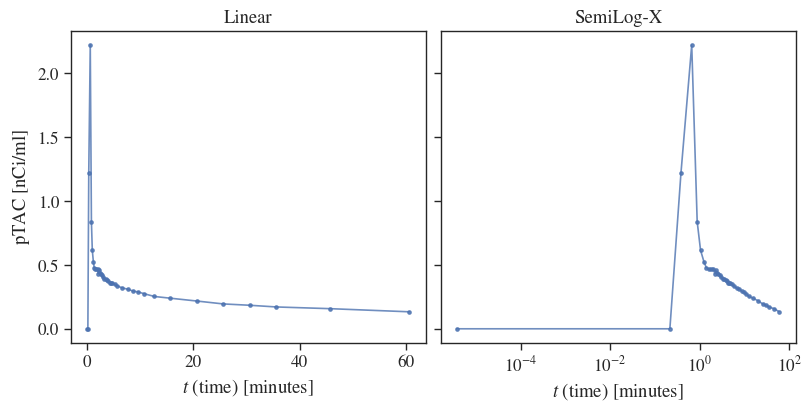

In [51]:
myFig, myAx = plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*aif_tac, '.-', alpha=0.8)
    anAx.set(xlabel=r'$t$ (time) [minutes]')
myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')

plt.show()

## Resampling pTAC At Scanner Frame Times

### Loading In Scanner Frame Times

In [40]:
scanner_times = []
with open("../../../../PracticeData/ScannerFrameTimes_CMS/1179307_v2_info.json") as dFile:
    scanner_times = np.array(json.load(dFile)['FrameReferenceTime'], order='C', dtype=float)/60.
scanner_times

array([2.49981667e-02, 1.08331500e-01, 1.91665000e-01, 2.74998333e-01,
       3.58331667e-01, 4.41665000e-01, 5.24998333e-01, 6.08331667e-01,
       6.91665000e-01, 7.74998333e-01, 8.58331667e-01, 9.41665000e-01,
       1.02499833e+00, 1.10833167e+00, 1.19166500e+00, 1.27499833e+00,
       1.35833167e+00, 1.44166500e+00, 1.52499833e+00, 1.60833167e+00,
       1.69166667e+00, 1.77500000e+00, 1.85833333e+00, 1.94166667e+00,
       2.14996667e+00, 2.48330000e+00, 2.81663333e+00, 3.14996667e+00,
       3.48330000e+00, 3.81663333e+00, 4.14996667e+00, 4.48330000e+00,
       4.81663333e+00, 5.48306667e+00, 6.48306667e+00, 7.48306667e+00,
       8.48306667e+00, 9.48306667e+00, 1.04830667e+01, 1.14830667e+01,
       1.24830667e+01, 1.34830667e+01, 1.44830667e+01, 1.74768333e+01,
       2.24768333e+01, 2.74768333e+01, 3.24768333e+01, 3.74768333e+01,
       4.24768333e+01, 4.74768333e+01, 5.24768333e+01, 5.74768333e+01])

### Interpolating pTAC On Scanner Frame Times

In [41]:
from pet_cli.blood_input import BloodInputFunction

In [42]:
scanner_aif = BloodInputFunction(time=aif_tac[0], activity=aif_tac[1], thresh_in_mins=30.0)
aif_on_scanner_tac = np.array([scanner_times, scanner_aif.calc_blood_input_function(x=scanner_times)],
                           dtype=float, order='C')

### Plotting Resampled pTAC

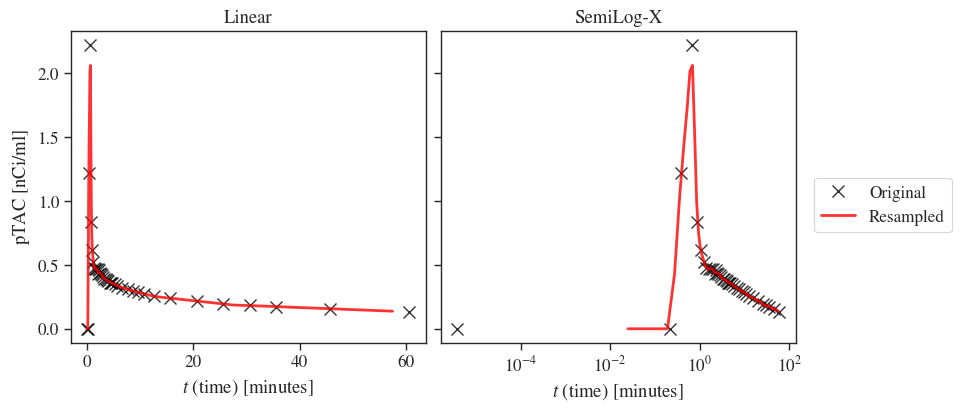

In [53]:
myFig, myAx = plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*aif_tac, 'x', alpha=0.8, label='Original', color='black', ms=8)
    anAx.plot(*aif_on_scanner_tac, '-', alpha=0.8, label='Resampled', color='red', lw=2)
    anAx.set(xlabel=r'$t$ (time) [minutes]')
    
    

myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')

plt.show()

### Saving Resampled pTAC To File

In [55]:
np.savetxt(fname="../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt", 
           X=aif_on_scanner_tac.T,
          header='Time (s), Activity (nCu)', fmt='%.6e')

# Generating Parametric Images: Explicitly Looping Over All Voxels

## Reusing `patlak_analysis` from `graphical_analysis`

In [62]:
@numba.njit()
def gen_patlak_parametric_image(pTAC_times: np.ndarray, pTAC_vals: np.ndarray,
                                tTAC_img, t_thresh_in_mins: float) -> np.ndarray:
    img_dims = tTAC_img.shape
    
    patlak_ki_img = np.zeros((img_dims[0], img_dims[1], img_dims[2]), float)
    patlak_vt_img = np.zeros_like(patlak_ki_img)
    
    for i in range(0, img_dims[0], 1):
        for j in range(0, img_dims[1], 1):
            for k in range(0, img_dims[2], 1):
                patlak_vals = pet_grph.patlak_analysis(input_tac_values=pTAC_vals, 
                                                       region_tac_values=tTAC_img[i,j,k,:],
                                                       tac_times_in_minutes=pTAC_times,
                                                       t_thresh_in_minutes=t_thresh_in_mins)
                patlak_ki_img[i,j,k]=patlak_vals[0]
                patlak_vt_img[i,j,k]=patlak_vals[1]
    return patlak_ki_img, patlak_vt_img

tmp_param_imgs = gen_patlak_parametric_image(pTAC_times=aif_on_scanner_tac[0],
                                             pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals[xDim//2-10:xDim//2+10, 
                                                              yDim//2-10:yDim//2+10, 
                                                              zDim//2-10:zDim//2+10, :],
                                            t_thresh_in_mins=30.0)

In [95]:
# %%timeit
tmp_param_imgs = gen_patlak_parametric_image(pTAC_times=aif_on_scanner_tac[0],
                                             pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals,
                                            t_thresh_in_mins=30.0)

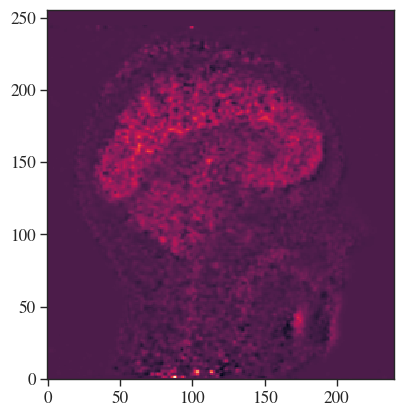

In [65]:
plt.imshow(tmp_param_imgs[0][xDim//2,:,:].T, interpolation='none', origin='lower')
plt.show()

## Testing New Implementation To Take Out Redundant Patlak-X Calculations

In [66]:
@numba.njit()
def gen_patlak_parametric_image_v2(pTAC_times: np.ndarray, pTAC_vals: np.ndarray,
                                tTAC_img, t_thresh_in_mins: float) -> np.ndarray:
    img_dims = tTAC_img.shape
    
    patlak_ki_img = np.zeros((img_dims[0], img_dims[1], img_dims[2]), float)
    patlak_vt_img = np.zeros_like(patlak_ki_img)
    
    t_thresh = pet_grph.get_index_from_threshold(times_in_minutes=pTAC_times, 
                                        t_thresh_in_minutes=t_thresh_in_mins)
    
    patlak_x = pet_grph.calculate_patlak_x(tac_times=pTAC_times, tac_vals=pTAC_vals)
    
    inv_pTAC_vals = 1.0/pTAC_vals[:]
    
    for i in range(0, img_dims[0], 1):
        for j in range(0, img_dims[1], 1):
            for k in range(0, img_dims[2], 1):
                patlak_y = tTAC_img[i,j,k,:]*inv_pTAC_vals[:]
                patlak_vals = pet_grph.fit_line_to_data_using_lls(xdata=patlak_x[t_thresh:], 
                                                                  ydata=patlak_y[t_thresh:])
                patlak_ki_img[i,j,k]=patlak_vals[0]
                patlak_vt_img[i,j,k]=patlak_vals[1]
    return patlak_ki_img, patlak_vt_img

tmp_param_imgs = gen_patlak_parametric_image_v2(pTAC_times=aif_on_scanner_tac[0],
                                             pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals[xDim//2-10:xDim//2+10, yDim//2-10:yDim//2+10, zDim//2-10:zDim//2+10, :],
                                            t_thresh_in_mins=30.0)

In [96]:
# %%timeit
tmp_param_imgs_v2 = gen_patlak_parametric_image_v2(pTAC_times=aif_on_scanner_tac[0],
                                             pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals,
                                            t_thresh_in_mins=30.0)

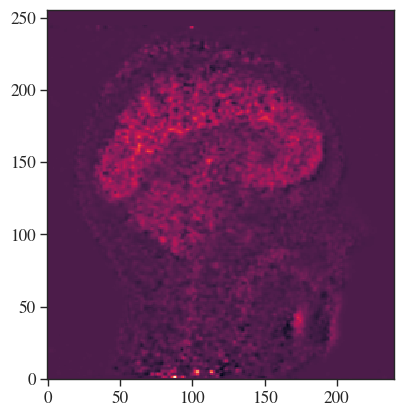

In [97]:
plt.imshow(tmp_param_imgs[0][xDim//2,:,:].T, interpolation='none', origin='lower')
plt.show()

In [77]:
np.allclose(tmp_param_imgs[0] - tmp_param_imgs_v2[0], 0.0)

True

## Testing The Logan Analysis By Reusing `logan_analysis` from `graphical_analysis`

In [136]:
from typing import Tuple
@numba.njit()
def gen_logan_parametric_image(pTAC_times: np.ndarray,
                               pTAC_vals: np.ndarray,
                               tTAC_img,
                               t_thresh_in_mins: float) -> Tuple[np.ndarray, np.ndarray]:
    img_dims = tTAC_img.shape
    
    logan_slope_img = np.zeros((img_dims[0], img_dims[1], img_dims[2]), float)
    logan_intercept_img = np.zeros_like(logan_slope_img)
    
    for i in range(0, img_dims[0], 1):
        for j in range(0, img_dims[1], 1):
            for k in range(0, img_dims[2], 1):
                logan_vals = pet_grph.logan_analysis(input_tac_values=pTAC_vals,
                                                     region_tac_values=tTAC_img[i, j, k, :],
                                                     tac_times_in_minutes=pTAC_times,
                                                     t_thresh_in_minutes=t_thresh_in_mins)
                logan_slope_img[i, j, k] = logan_vals[0]
                logan_intercept_img[i, j, k] = logan_vals[1]
    return logan_slope_img, logan_intercept_img


tmp_param_imgs = gen_logan_parametric_image(pTAC_times=aif_on_scanner_tac[0], 
                                            pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals[xDim // 2 - 10:xDim // 2 + 10,
                                                              yDim // 2 - 10:yDim // 2 + 10, 
                                                              zDim // 2 - 10:zDim // 2 + 10, :],
                                            t_thresh_in_mins=30.0)

In [150]:
print(img_vals.max())
print(img_vals.min())

49.28864527027027
-5.587725506756756


In [137]:
tmp_param_imgs = gen_logan_parametric_image(pTAC_times=aif_on_scanner_tac[0],
                                            pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals,
                                            t_thresh_in_mins=30.0)

LinAlgError: Array must not contain infs or NaNs.

We will have to add some division by 0 checks in the logan analysis to circumvent this problem

## Testing A Template-Like Function

In [176]:
from typing import Tuple
@numba.njit()
def gen_parametric_image_with_graphical_method(pTAC_times: np.ndarray,
                                               pTAC_vals: np.ndarray,
                                               tTAC_img: np.ndarray,
                                               t_thresh_in_mins: float,
                                               analysis_func) -> Tuple[np.ndarray, np.ndarray]:
    img_dims = tTAC_img.shape
    
    slope_img = np.zeros((img_dims[0], img_dims[1], img_dims[2]), float)
    intercept_img = np.zeros_like(slope_img)
    
    for i in range(0, img_dims[0], 1):
        for j in range(0, img_dims[1], 1):
            for k in range(0, img_dims[2], 1):
                analysis_vals = analysis_func(input_tac_values=pTAC_vals, 
                                              region_tac_values=tTAC_img[i, j, k, :],
                                              tac_times_in_minutes=pTAC_times,
                                              t_thresh_in_minutes=t_thresh_in_mins)
                slope_img[i, j, k] = analysis_vals[0]
                intercept_img[i, j, k] = analysis_vals[1]
    return slope_img, intercept_img

In [177]:
tmp_patlak_img = gen_parametric_image_with_graphical_method(pTAC_times=aif_on_scanner_tac[0],
                                                            pTAC_vals=aif_on_scanner_tac[1],
                                                            tTAC_img=img_vals,
                                                            t_thresh_in_mins=30.0,
                                                            analysis_func=pet_grph.patlak_analysis)

### Plotting A Histogram Of Slope ($K_1$) Values Over The Brain

In [162]:
brain_mask = nibabel.load(f"{DATA_DIR}/4DPET/1179307_v2_mpr_BET_mask.nii.gz").get_fdata()

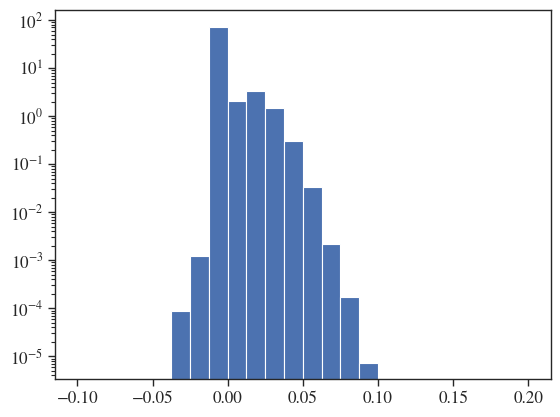

In [163]:
plt.hist((tmp_patlak_img[0]*brain_mask).flatten(), density=True, bins=np.linspace(-0.1, 0.2, 25))
plt.yscale('log')
plt.show()

# Comparing Test Implementation With Package Implementation

In [3]:
import pet_cli.parametric_images as pet_pim

In [179]:
tmp_patlak_img = gen_parametric_image_with_graphical_method(pTAC_times=aif_on_scanner_tac[0],
                                                            pTAC_vals=aif_on_scanner_tac[1],
                                                            tTAC_img=img_vals,
                                                            t_thresh_in_mins=30.0,
                                                            analysis_func=pet_grph.patlak_analysis)

In [181]:
tmp_patlak_img_new = pet_pim.generate_parametric_images_with_graphical_method(pTAC_times=aif_on_scanner_tac[0],
                                                            pTAC_vals=aif_on_scanner_tac[1],
                                                            tTAC_img=img_vals,
                                                            t_thresh_in_mins=30.0,
                                                            method_name='patlak')

In [184]:
np.allclose(tmp_patlak_img[0] - tmp_patlak_img_new [0], 0.0)

True

# Testing Writing Parametric Images Using The Class

In [26]:
from importlib import reload
reload(pet_pim)
reload(pet_grph)

<module 'pet_cli.graphical_analysis' from '/Users/furqandar/Library/Python/3.9/lib/python/site-packages/pet_cli/graphical_analysis.py'>

In [103]:
patlak_pim = pet_pim.GraphicalAnalysisParametricImage(input_tac_path='../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt',
                                                     pet4D_img_path='../../../../PracticeData/4DPET/1179307_v2_FDG_on_mpr.nii.gz',
                                                     output_directory='../../../../PracticeData/4DPET/',
                                                     output_filename_prefix='test')

In [104]:
patlak_pim.run_analysis(method_name='patlak', t_thresh_in_mins=30.0)

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/pet_cli/parametric_images.py:474: UserWarning: PET image values are being divided by 37000 for unit conversion to Bq/cc.
  * :func:`pet_cli.graphical_analysis.logan_analysis`


In [105]:
patlak_pim.save_parametric_images()
patlak_pim.save_analysis_properties()

# Testing Calculating $R^2$-Values For Simple TACs

## Loading And Plotting

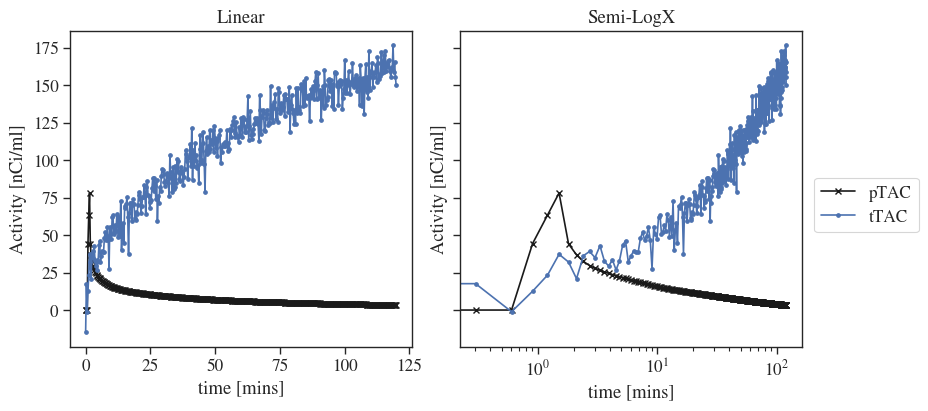

In [55]:
pTAC = pet_pim._safe_load_tac(filename='../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt')
tTAC = pet_pim._safe_load_tac(filename='../../data/tcm_tacs/serial_2tcm_k4zero/gaussian_noise/tac_2tcm_k4zero_set-01.txt')
myFig, myAx =plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*pTAC, 'x-', label='pTAC', color='k')
    anAx.plot(*tTAC, '.-', label='tTAC')
    
myAx[0].set(title='Linear', ylabel='Activity [nCi/ml]', xlabel='time [mins]')
myAx[1].set(title='Semi-LogX', ylabel='Activity [nCi/ml]', xlabel='time [mins]', xscale='log')
myFig.legend(*myAx.flatten()[0].get_legend_handles_labels(), bbox_to_anchor=(1.0,0.5), loc='center left')
plt.show()

/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_25540/2154285610.py:2: RuntimeWarning: divide by zero encountered in divide
  patlak_y = tTAC[1]/pTAC[1]


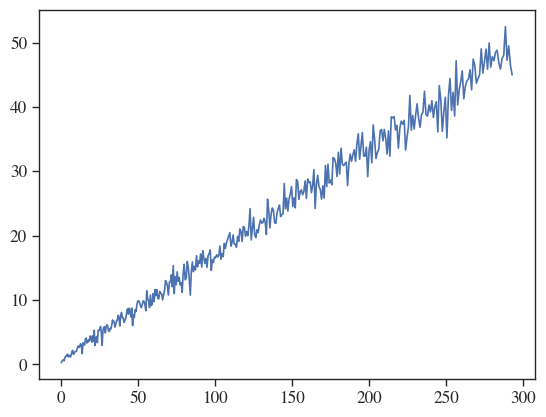

In [62]:
patlak_x = pet_grph.calculate_patlak_x(*pTAC)
patlak_y = tTAC[1]/pTAC[1]
plt.plot(patlak_x, patlak_y)
plt.show()

## Calculating The $R^2$-Value

In [74]:
@numba.njit()
def fit_line_to_data_using_lls_with_rsquared(xdata: np.ndarray, ydata: np.ndarray) -> np.ndarray:
    make_2d_matrix = pet_grph._line_fitting_make_rhs_matrix_from_xdata
    matrix = make_2d_matrix(xdata)
    fit_ans = np.linalg.lstsq(matrix, ydata)
    
    ss_res = fit_ans[1][0]
    ss_tot = np.sum((np.mean(ydata)-ydata)**2.)
    r_squared = 1.0 - ss_res/ss_tot
    return fit_ans[0][0], fit_ans[0][1], r_squared

In [75]:
patlak_x = pet_grph.calculate_patlak_x(*pTAC)
fit_line_to_data_using_lls_with_rsquared(xdata=patlak_x[-200:], ydata=tTAC[1][-200:]/pTAC[1][-200:])

(0.16214861131075553, 1.1403325897642231, 0.9525494311232554)

## Testing Implementation Of Saving Analysis Properties From TACs

In [99]:
reload(pet_pim)
reload(pet_grph)

<module 'pet_cli.graphical_analysis' from '/Users/furqandar/Library/Python/3.9/lib/python/site-packages/pet_cli/graphical_analysis.py'>

In [106]:
tacs_obj = pet_grph.GraphicalAnalysis(input_tac_path="../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt",
                                     roi_tac_path="../../data/tcm_tacs/serial_2tcm_k4zero/gaussian_noise/tac_2tcm_k4zero_set-01.txt",
                                     output_directory="../../../../PracticeData/4DPET/",
                                     output_filename_prefix='test')

In [109]:
tacs_obj.run_analysis(method_name='logan', t_thresh_in_mins=30.0)

In [110]:
tacs_obj.save_analysis()

# Prototyping Fixing Logan Analysis Division By 0

## Re-creating Bug

In [119]:
reload(pet_pim)
reload(pet_grph)

<module 'pet_cli.graphical_analysis' from '/Users/furqandar/Library/Python/3.9/lib/python/site-packages/pet_cli/graphical_analysis.py'>

In [188]:
aif_on_scanner = pet_grph._safe_load_tac('../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt')

In [120]:
tmp_logan_img_new = pet_pim.GraphicalAnalysisParametricImage(input_tac_path='../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt',
                                                     pet4D_img_path='../../../../PracticeData/4DPET/1179307_v2_FDG_on_mpr.nii.gz',
                                                     output_directory='../../../../PracticeData/4DPET/',
                                                     output_filename_prefix='test')

In [121]:
tmp_logan_img_new.run_analysis(method_name='logan', t_thresh_in_mins=40.0)

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/pet_cli/parametric_images.py:474: UserWarning: PET image values are being divided by 37000 for unit conversion to Bq/cc.
  warnings.warn("PET image values are being divided by 37000 for unit conversion to Bq/cc.", UserWarning)


LinAlgError: Array must not contain infs or NaNs.

## Finding Voxels That Fail

In [126]:
img_vals.shape

(176, 240, 256, 52)

In [171]:
step_size = 1
img_num_zeros = np.zeros((xDim//step_size, yDim//step_size, zDim//step_size), dtype=float)
for i, x_slice in enumerate(img_vals[::step_size]):
    for j, y_slice in enumerate(x_slice[::step_size]):
        for k, t_tac in enumerate(y_slice[::step_size]):
            img_num_zeros[i,j,k] = len(np.argwhere(t_tac==0).T[0])
#             print((i*100,j*100,k*100), len(np.argwhere(t_tac==0).T[0]))
#             print((i*100,j*100,k*100), np.argwhere(t_tac==0).T)

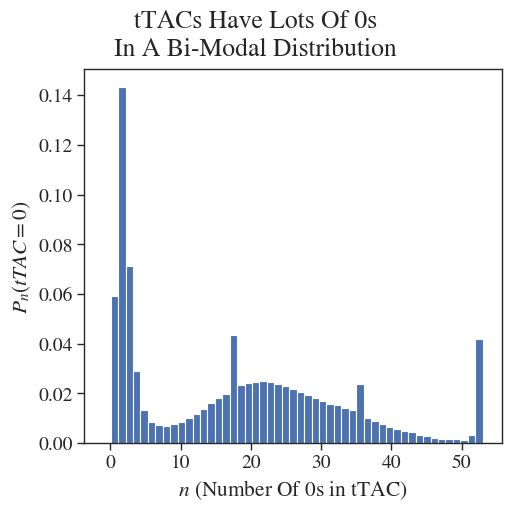

In [172]:
myFig, myAx = plt.subplots(1,1, constrained_layout=True, figsize=(5,5))
myAx.hist(img_num_zeros.flatten(), density=True, bins=np.linspace(0-1, 52+1, 52))
plt.ylabel(r"$P_n(tTAC=0)$")
plt.xlabel(r"$n$ (Number Of 0s in tTAC)")
myFig.suptitle("tTACs Have Lots Of 0s\nIn A Bi-Modal Distribution", ha='center', va='top')
plt.show()

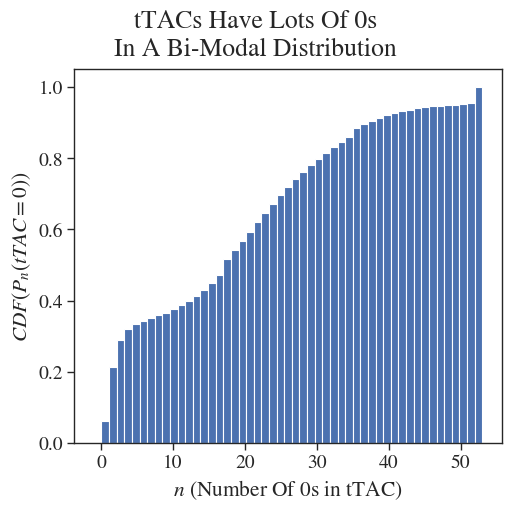

In [173]:
myFig, myAx = plt.subplots(1,1, constrained_layout=True, figsize=(5,5))
myAx.hist(img_num_zeros.flatten(), density=True, bins=np.linspace(0-1, 52+1, 52), cumulative=True)
plt.ylabel(r"$CDF(P_n(tTAC=0))$")
plt.xlabel(r"$n$ (Number Of 0s in tTAC)")
myFig.suptitle("tTACs Have Lots Of 0s\nIn A Bi-Modal Distribution", ha='center', va='top')
plt.show()

### Getting The Voxles With $\leq 5$ 0's and $\geq 40$ 0's

In [199]:
voxel_ids_with_at_most_5_zeros = np.argwhere(img_num_zeros <= 5)
voxel_ids_with_at_most_5_zeros = np.argwhere(img_num_zeros <= 5)
voxel_ids_with_at_most_5_zeros.shape

(3618578, 3)

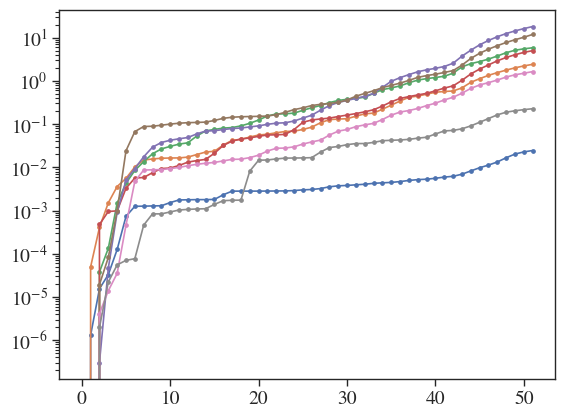

In [201]:
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//2]:
    plt.plot(pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=img_vals[an_id[0],an_id[1],an_id[2]]),
            '.-')
plt.yscale('log')
plt.show()

In [200]:
voxel_ids_with_at_least_40_zeros = np.argwhere(img_num_zeros >= 40)
voxel_ids_with_at_least_40_zeros = np.argwhere(img_num_zeros >= 40)
voxel_ids_with_at_least_40_zeros.shape

(930538, 3)

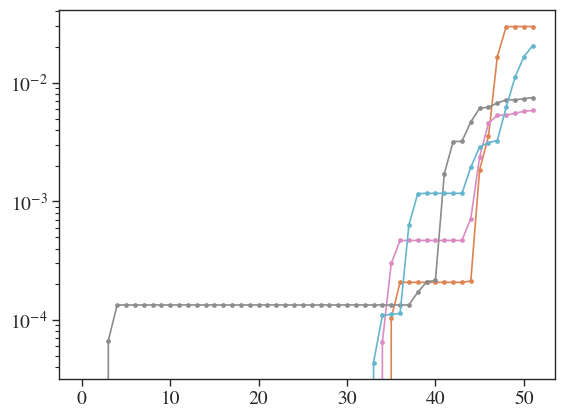

In [205]:
for an_id in voxel_ids_with_at_least_40_zeros[::1000000//10]:
    plt.plot(pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=img_vals[an_id[0],an_id[1],an_id[2]]),
            '.-')
plt.yscale('log')
plt.show()

## Plotting The Logan $X$ And $Y$ For Bad TACs

### With At Most 5 0's

#### Not-Dividing By $R(t)$ (Plotting $R(t)\cdot X$ and $R(t)\cdot Y$)

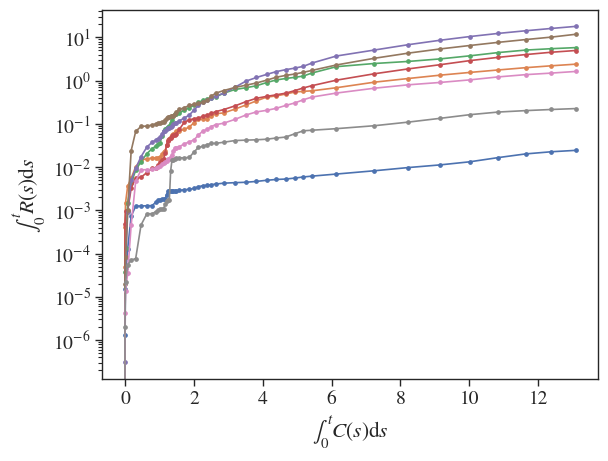

In [220]:
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//2]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)

    plt.plot(logan_x, logan_y, '.-')

plt.yscale('log')

plt.ylabel(r"$\int_{0}^{t}R(s)\mathrm{d}s$")
plt.xlabel(r"$\int_{0}^{t}C(s)\mathrm{d}s$")
plt.show()

#### Plotting True Logan $X$ and $Y$

/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_25540/2060525841.py:6: RuntimeWarning: divide by zero encountered in divide
  logan_x /= t_tac
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_25540/2060525841.py:6: RuntimeWarning: invalid value encountered in divide
  logan_x /= t_tac
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_25540/2060525841.py:7: RuntimeWarning: divide by zero encountered in divide
  logan_y /= t_tac
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_25540/2060525841.py:7: RuntimeWarning: invalid value encountered in divide
  logan_y /= t_tac


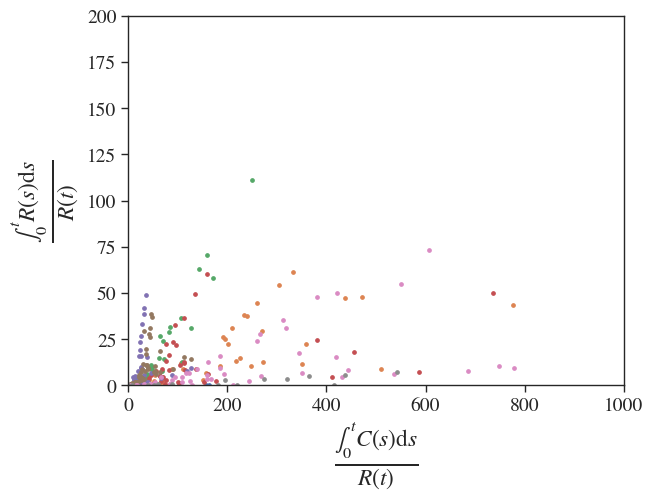

In [219]:
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//2]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)

    logan_x /= t_tac
    logan_y /= t_tac
    
    plt.plot(logan_x, logan_y, '.')

# plt.yscale('log')
plt.ylim(0,200)
plt.xlim(0,1000)
plt.ylabel(r"$\frac{\int_{0}^{t}R(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.xlabel(r"$\frac{\int_{0}^{t}C(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.show()

### With At Least 40 0's

#### Not-Dividing By $R(t)$ (Plotting $R(t)\cdot X$ and $R(t)\cdot Y$)

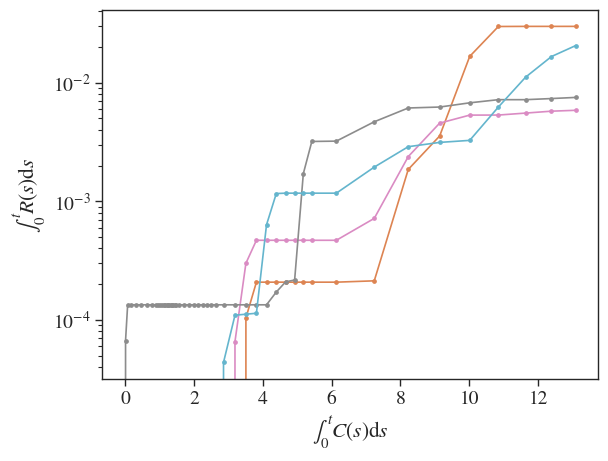

In [224]:
for an_id in voxel_ids_with_at_least_40_zeros[::1000000//10]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)

    plt.plot(logan_x, logan_y, '.-')

plt.yscale('log')

plt.ylabel(r"$\int_{0}^{t}R(s)\mathrm{d}s$")
plt.xlabel(r"$\int_{0}^{t}C(s)\mathrm{d}s$")
plt.show()

#### Plotting True Logan $X$ and $Y$

/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_25540/3134308190.py:6: RuntimeWarning: divide by zero encountered in divide
  logan_x /= t_tac
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_25540/3134308190.py:6: RuntimeWarning: invalid value encountered in divide
  logan_x /= t_tac
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_25540/3134308190.py:7: RuntimeWarning: divide by zero encountered in divide
  logan_y /= t_tac
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_25540/3134308190.py:7: RuntimeWarning: invalid value encountered in divide
  logan_y /= t_tac


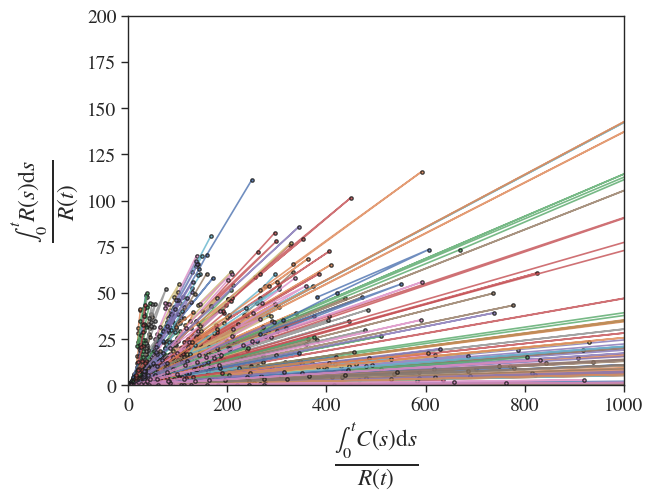

In [227]:
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//10]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)

    logan_x /= t_tac
    logan_y /= t_tac
    
    plt.plot(logan_x, logan_y, '.-', mec='k', alpha=0.8)

# plt.yscale('log')
plt.ylim(0,200)
plt.xlim(0,1000)
plt.ylabel(r"$\frac{\int_{0}^{t}R(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.xlabel(r"$\frac{\int_{0}^{t}C(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.show()

## Simply Ignoring The 0s For Calculations

### With At Most 5 0's

#### Not-Dividing By $R(t)$ (Plotting $R(t)\cdot X$ and $R(t)\cdot Y$)

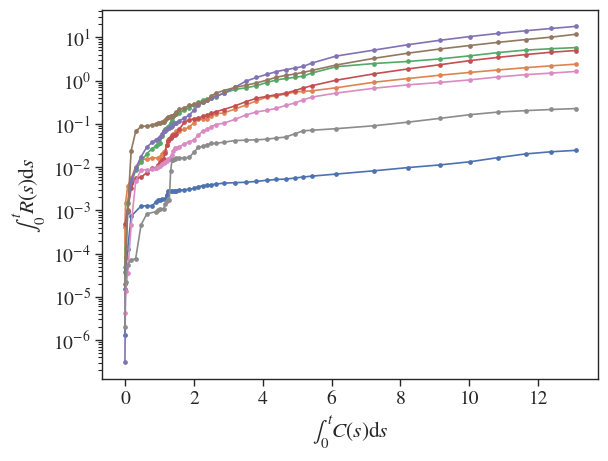

In [235]:
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//2]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)
    
    good_points = np.argwhere(t_tac != 0.).T[0]
    
    
    plt.plot(logan_x[good_points], logan_y[good_points], '.-')

plt.yscale('log')

plt.ylabel(r"$\int_{0}^{t}R(s)\mathrm{d}s$")
plt.xlabel(r"$\int_{0}^{t}C(s)\mathrm{d}s$")
plt.show()

#### True Logan Plots

[ 1  2  3  4  5  7  8  9 10 11 12 13 15 16 17 19 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51]
[ 1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51]
[ 2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 

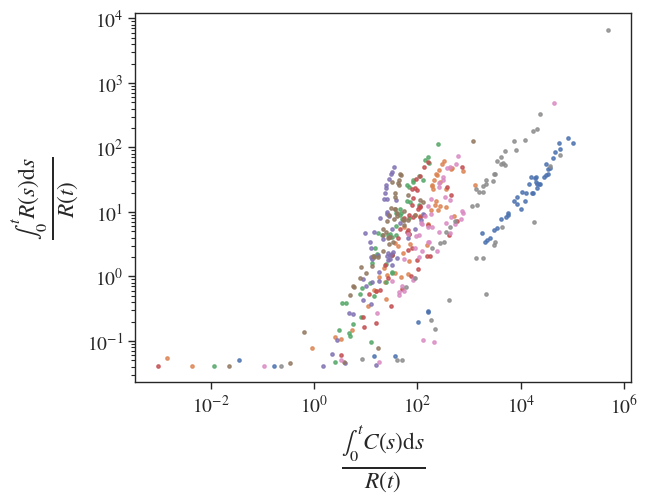

In [253]:
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//2]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)
    
    good_points = np.argwhere(t_tac != 0.).T[0]
    print(good_points)
    logan_x = logan_x[good_points] / t_tac[good_points]
    logan_y = logan_y[good_points] / t_tac[good_points]
    
    plt.plot(logan_x, logan_y, '.', alpha=0.8)

plt.yscale('log')
plt.xscale('log')
# plt.ylim(0,200)
# plt.xlim(0,1000)
plt.ylabel(r"$\frac{\int_{0}^{t}R(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.xlabel(r"$\frac{\int_{0}^{t}C(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.show()

### With At Least 40 0's

#### Just The Cumulative Integrals

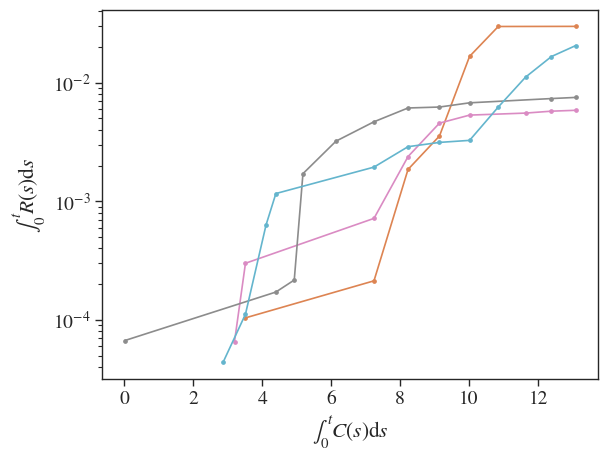

In [240]:
for an_id in voxel_ids_with_at_least_40_zeros[::1000000//10]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)

    good_points = np.argwhere(t_tac != 0.).T[0]
    
    
    plt.plot(logan_x[good_points], logan_y[good_points], '.-')

plt.yscale('log')

plt.ylabel(r"$\int_{0}^{t}R(s)\mathrm{d}s$")
plt.xlabel(r"$\int_{0}^{t}C(s)\mathrm{d}s$")
plt.show()

#### True Logan Plots

[]
[35 44 45 46 47 48 51]
[]
[]
[]
[]
[34 35 44 45 46 47 49 50 51]
[ 3 38 40 41 43 44 45 46 47 50 51]
[]
[33 35 37 38 44 45 46 47 48 49 50 51]


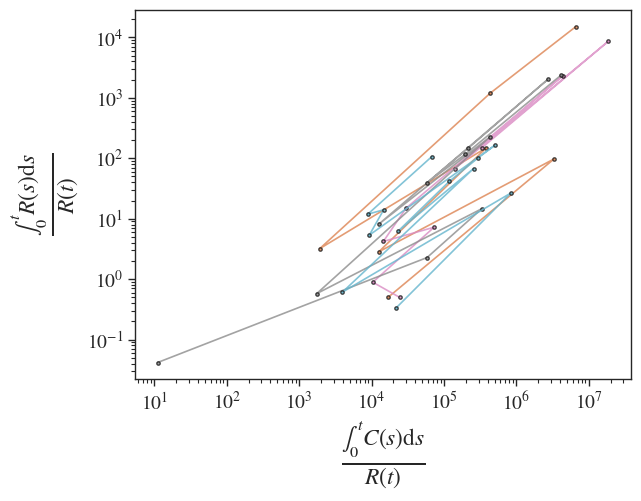

In [249]:
for an_id in voxel_ids_with_at_least_40_zeros[::1000000//10]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)

    good_points = np.argwhere(t_tac != 0.).T[0]
    print(good_points)
    logan_x = logan_x[good_points] / t_tac[good_points]
    logan_y = logan_y[good_points] / t_tac[good_points]
    
    plt.plot(logan_x, logan_y, '.-', mec='k', alpha=0.8)

plt.yscale('log')
plt.xscale('log')
# plt.ylim(0,200)
# plt.xlim(0,1000)
plt.ylabel(r"$\frac{\int_{0}^{t}R(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.xlabel(r"$\frac{\int_{0}^{t}C(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.show()